1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import seaborn as sns
%matplotlib inline

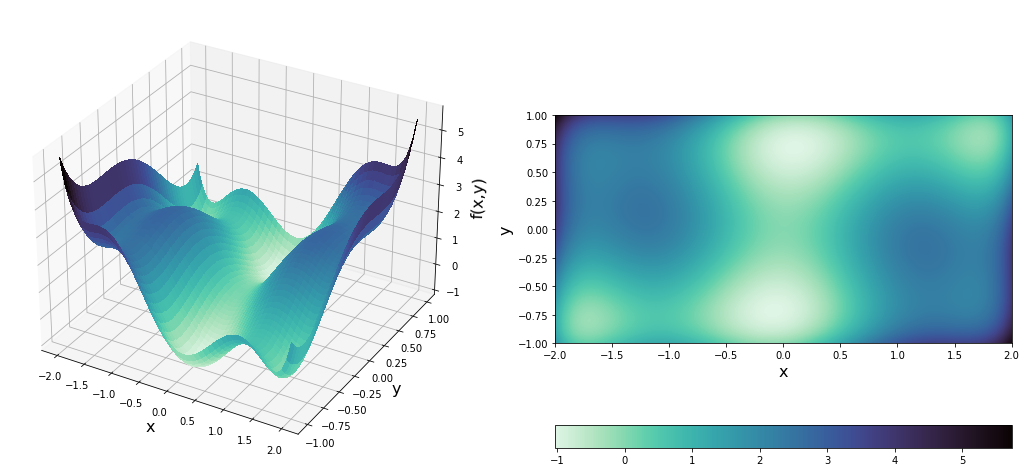

In [2]:
def camelbackfunc(x):
    return (4-2.1*x[0]*x[0]+x[0]**4/3.)*x[0]**2+x[0]*x[1]+(4*x[1]*x[1]-4)*x[1]**2

x = np.arange(-2.0, 2.0, 0.01)
y = np.arange(-1.0, 1.0, 0.01)

X, Y = np.meshgrid(x, y)
Z = camelbackfunc([X,Y])
fig =  plt.figure(figsize = (18, 10))
ax = fig.add_subplot(121, projection='3d')
surface = ax.plot_surface(X, Y, Z, cmap='mako_r',linewidth = 0, antialiased=False)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.set_zlabel('f(x,y)', fontsize=16)

ax1 = fig.add_subplot(122)
dens = ax1.imshow(Z, cmap='mako_r',extent=[-2, 2, -1, 1])
fig.colorbar(dens, orientation = 'horizontal', ax = ax1)
ax1.set_xlabel('x', fontsize=16)
ax1.set_ylabel('y', fontsize=16)
plt.show()

In [3]:
#To find the minima there are several optimize.minimize metods. 
#The criteria of which one to pick are very technical, more info can be found here: 
#https://scipy-lectures.org/advanced/mathematical_optimization/#choosing-a-method

#In my case I will try a couple of them.

algo = ['BFGS', 'L-BFGS-B', 'Powell', 'Nelder-Mead']

initial_guess = [np.random.uniform(-2,2), np.random.uniform(-1,1)]
minima = []
print('With initial guess', initial_guess,':\n')
for i, method in enumerate(algo):
    pos = optimize.minimize(camelbackfunc, initial_guess, method = method)
    if pos.success:
        minima.append(pos.x)
        print('Minimum found by the', method,'method is at point:',minima[i], 'and its value is: ', np.round(camelbackfunc(minima[i]),5))

print('\nThe values found vary from one run to the next, given that I have randomized the starting guess.')        
print('The determination of the global minima is in the next cell, however it\'s interesting to note that on some runs different algorithms give different results, WITH THE SAME INITIAL GUESS!')

initial_guess00 = [0,0]
minima00 = []
print('\n \n In the meantime it\'s worth noting that with an initial guess of', initial_guess00, ':\n')
for i, method in enumerate(algo):
    pos = optimize.minimize(camelbackfunc, initial_guess00, method = method)
    if pos.success:
        minima00.append(pos.x)
        print('Minimum found by the', method,'method is at point:',minima00[i], 'and its value is: ', np.round(camelbackfunc(minima00[i]),5))

print('\n With the origin as an initial guess, some algorithms "get stuck" since it is a saddle point in the function.')


With initial guess [-0.7755666666787562, -0.3889439406236357] :

Minimum found by the BFGS method is at point: [ 0.08984182 -0.71265641] and its value is:  -1.03163
Minimum found by the L-BFGS-B method is at point: [ 0.08984145 -0.71265574] and its value is:  -1.03163
Minimum found by the Powell method is at point: [-0.089842    0.71265634] and its value is:  -1.03163
Minimum found by the Nelder-Mead method is at point: [ 0.0898686  -0.71264889] and its value is:  -1.03163

The values found vary from one run to the next, given that I have randomized the starting guess.
The determination of the global minima is in the next cell, however it's interesting to note that on some runs different algorithms give different results, WITH THE SAME INITIAL GUESS!

 
 In the meantime it's worth noting that with an initial guess of [0, 0] :

Minimum found by the BFGS method is at point: [0. 0.] and its value is:  0.0
Minimum found by the L-BFGS-B method is at point: [0. 0.] and its value is:  0.0
Min

In [4]:
#Global minima and function value at those points. 

#From the plots the global minima can be given by only 6 points. 
initial_guesses_global = [[0, 0.75], [0,-0.75], [-1.75, -0.75], [-1.75, 0.75], [1.75, -0.75], [1.75, 0.75] ]

global_minima = []
values = []
for i, guess in enumerate(initial_guesses_global):
    print('\nWith initial guess', guess,':')
    pos = optimize.minimize(camelbackfunc, guess)
    if pos.success:
        global_minima.append(pos.x)
        values.append(camelbackfunc(global_minima[i]))
        print('Minimum found is at point:',global_minima[i], 'and its value is: ', values[i])
        
print('\nThe minimum value found is',np.array(values).min())
print('This is the value of the function evaluated at points: ', global_minima[0], 'and', global_minima[1])
print('The function in fact is even (i.e. it respects the equality f(x,y) = f(-x,-y)). So we get two global minima.')





With initial guess [0, 0.75] :
Minimum found is at point: [-0.08984202  0.71265641] and its value is:  -1.0316284534898768

With initial guess [0, -0.75] :
Minimum found is at point: [ 0.08984201 -0.71265642] and its value is:  -1.0316284534898743

With initial guess [-1.75, -0.75] :
Minimum found is at point: [ 0.08984197 -0.71265633] and its value is:  -1.0316284534898348

With initial guess [-1.75, 0.75] :
Minimum found is at point: [-1.70360666  0.79608374] and its value is:  -0.21546382438334832

With initial guess [1.75, -0.75] :
Minimum found is at point: [ 1.70360664 -0.79608375] and its value is:  -0.2154638243832634

With initial guess [1.75, 0.75] :
Minimum found is at point: [-0.08984198  0.71265632] and its value is:  -1.0316284534898204

The minimum value found is -1.0316284534898768
This is the value of the function evaluated at points:  [-0.08984202  0.71265641] and [ 0.08984201 -0.71265642]
The function in fact is even (i.e. it respects the equality f(x,y) = f(-x,-y))

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

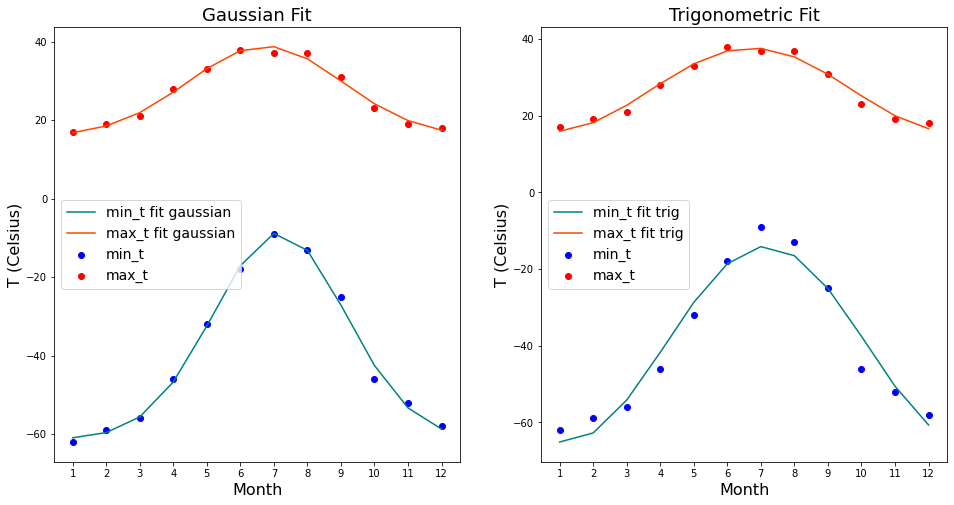

R2 for gaussian fits are respectively: 

R2 fit min temperatures:  0.9946041936397241
R2 fit max temperatures:  0.9858796078357842

R2 for trigonometric fits are respectively:

R2 fit min temperatures:  0.9570699008184621
R2 fit max temperatures:  0.9766752925627983

The result is reasonable.

GAUSSIAN FIT:
The mean of the fitted data are: 
Mean of the minimum temperatures: 7.16453 +/- 0.04721
Mean of the maximum temperatures: 6.73582 +/- 0.07947


In [5]:
#Plot these temperatures

months = np.array([i for i in range (1,13)])
min_t = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
max_t = np.array([ 17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121)
ax1.set_title('Gaussian Fit', fontsize = 18)
ax1.set_xlabel('Month', size = 16)
ax1.set_ylabel('T (Celsius)',size = 16)
plt.xticks(months)
ax1.scatter(months, min_t, label = 'min_t', color = 'blue')
ax1.scatter(months, max_t, label = 'max_t', color = 'red')

#Find a suitable a function that can describe min and max temperatures.

#First thought that came to mind is a gaussian
def func(x, a, b, c, k):
    return a*np.exp(-0.5*((x-b)**2)/c) + k

#Then i tried also with a trigonometric function, since ideally the max and min temperatures vary with
#continuity and repeat each year
def functrig(t, a, b, c):
    return a*np.cos(((2*np.pi*t) + b)/12) + c


#Fit this function to the data with scipy.optimize.curve_fit().
#I had to supply an initial guess to the min_t values, and I did so by eyeballing them w.r.t. the results
#of the optimization with the max_t values
param_max, param_max_cov = optimize.curve_fit(func, months, max_t)
param_min, param_min_cov = optimize.curve_fit(func, months, min_t, p0 = [30, 6.7, 3, -60])

param_max_trig, param_max_trig_cov = optimize.curve_fit(functrig, months, max_t, [15, 0, 12])
param_min_trig, param_min_trig_cov = optimize.curve_fit(functrig, months, min_t, [30, 0, -40])


#Plot the result.
ax1.plot(months, func(months, *param_min), c = 'teal', label = 'min_t fit gaussian')
ax1.plot(months, func(months, *param_max), c = 'orangered', label = 'max_t fit gaussian')

ax2 = fig.add_subplot(122)
ax2.set_title('Trigonometric Fit', fontsize = 18)
ax2.set_xlabel('Month', size = 16)
ax2.set_ylabel('T (Celsius)',size = 16)
plt.xticks(months)
ax2.scatter(months, min_t, label = 'min_t', color = 'blue')
ax2.scatter(months, max_t, label = 'max_t', color = 'red')
ax2.plot(months, functrig(months, *param_min_trig), c = 'teal', label = 'min_t fit trig')
ax2.plot(months, functrig(months, *param_max_trig), c = 'orangered', label = 'max_t fit trig')


ax1.legend(loc = 'best', fontsize = 14)
ax2.legend(loc = 'best', fontsize = 14)


plt.show()

#Is the fit reasonable? If not, why?

#Calculate R2 gaussian fit
gaussian_pred_min = func(months, *param_min)
ssr_gauss_min = np.sum((gaussian_pred_min-min_t)**2)
tss_min = np.sum((np.mean(min_t) - min_t)**2)
gaussian_pred_max = func(months, *param_max)
ssr_gauss_max = np.sum((gaussian_pred_max-max_t)**2)
tss_max = np.sum((np.mean(max_t) - max_t)**2)
n_dof_gauss = 3
RSQ_gauss_min = 1 - (ssr_gauss_min/tss_min)
RSQ_gauss_max = 1 - (ssr_gauss_max/tss_max)

print('R2 for gaussian fits are respectively: \n')
print('R2 fit min temperatures: ', RSQ_gauss_min)
print('R2 fit max temperatures: ', RSQ_gauss_max)

#Calculate R2 trigonometric fit
trig_pred_min = functrig(months, *param_min_trig)
ssr_trig_min = np.sum((trig_pred_min-min_t)**2)
trig_pred_max = functrig(months, *param_max_trig)
ssr_trig_max = np.sum((trig_pred_max-max_t)**2)
n_dof_trig = 2
RSQ_trig_min = 1 - (ssr_trig_min/tss_min)
RSQ_trig_max = 1 - (ssr_trig_max/tss_max)

print('\nR2 for trigonometric fits are respectively:\n')
print('R2 fit min temperatures: ', RSQ_trig_min)
print('R2 fit max temperatures: ', RSQ_trig_max)


print('\nThe result is reasonable.\n')

#Is the time offset for min and max temperatures the same within the fit accuracy?
print('GAUSSIAN FIT:')

param_err_min= np.sqrt(np.diag(param_min_cov))
param_err_max= np.sqrt(np.diag(param_max_cov))
print('The mean of the fitted data are: ')
print('Mean of the minimum temperatures:', np.round(param_min[1],5), '+/-', np.round(param_err_min[1],5))
print('Mean of the maximum temperatures:', np.round(param_max[1],5), '+/-', np.round(param_err_max[1],5))




3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

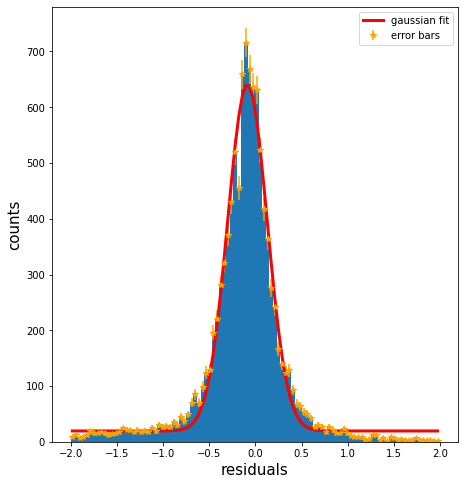

chi2 = 6158.660467117281
p-value = 0.0
Fit is unsatisfactory.


In [6]:
import pandas as pd
from scipy import stats

data_res = pd.DataFrame(np.load('data/residuals_261.pkl', allow_pickle = True).item())

#I choose a threshold 

data_res = data_res[abs(data_res['residuals'])<2]

fig = plt.figure(figsize=(16, 8))
ax1 = plt.subplot(121)
ax1.set_xlabel('residuals', fontsize = 15)
ax1.set_ylabel('counts', fontsize = 15)
hist = ax1.hist(data_res['residuals'], bins = int(np.sqrt(len(data_res['residuals']))))

midpoint = (hist[1][1:] + hist[1][:-1])/2

#Set appropriate possion uncertainty of each bin.

ax1.errorbar(midpoint, hist[0], yerr = np.sqrt(hist[0]), fmt='*', color = 'orange', label = 'error bars')

#I decide to fit a gaussian distribution to the data

def funcres(x, a, b, c, k):
    return a*np.exp(-0.5*((x-b)**2)/c) + k

res_param, res_param_cov = optimize.curve_fit(funcres, midpoint, hist[0], p0 = [1000, 0, 0.5, 0])
ax1.plot(midpoint, funcres(midpoint, *res_param), color = 'red', linewidth = 3, label = 'gaussian fit')
plt.legend(loc = 'best')
plt.show()


#Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?
ndof = len(midpoint) - 1
#print("n degrees of freedom =", ndof)
pred_data = funcres(midpoint, *res_param)
# calculate the chi^2
chi2 = np.sum((hist[0]-pred_data)**2 / (np.sqrt(hist[0]+1)))
print("chi2 =", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the cumulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

print('Fit is unsatisfactory.')



4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

It's clear that there weren't days with a temperature of 100 degrees, so we drop those data points


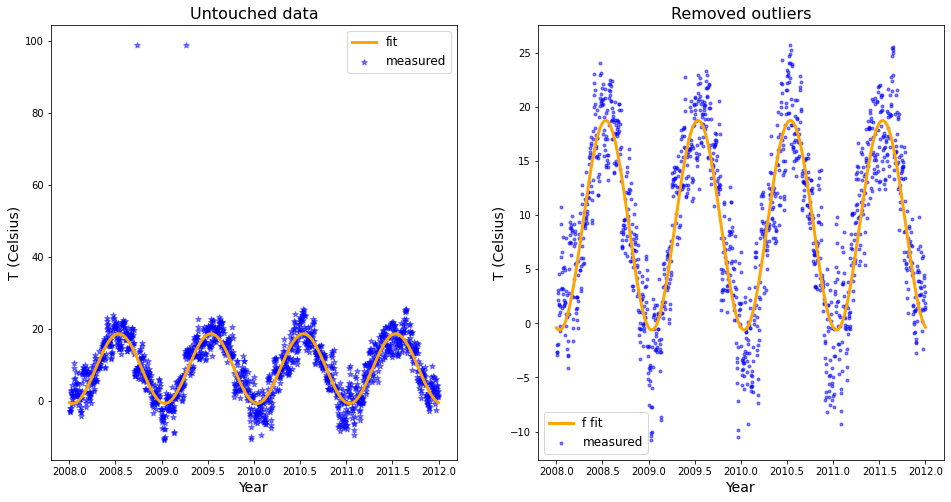

In [7]:
import pandas as pd
from IPython.display import display


munich_temp_df = pd.read_csv('munich_temperatures_average_with_bad_data.txt', header = None, delimiter = ' ')
#display(munich_temp_df)
def f(t,a,b,c):
    return a*np.cos((2*np.pi*t) + b) + c

#Fit the data
parameters, parameter_cov = optimize.curve_fit(f, munich_temp_df[0], munich_temp_df[1])

#Make a plot of the data and the best-fit model in the range 2008 to 2012.

df_2008_2012 = munich_temp_df.iloc[4748:6209]

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121)
ax1.set_title('Untouched data', fontsize = 16)
ax1.set_xlabel('Year', size = 14)
ax1.set_ylabel('T (Celsius)',size = 14)
ax1.scatter(df_2008_2012[0], df_2008_2012[1], label = 'measured', color = 'blue', marker = '*', alpha = 0.5)
ax1.plot(df_2008_2012[0], f(df_2008_2012[0], *parameters), c = 'orange',label = 'fit', linewidth = 3)
ax1.legend(loc = 'best', fontsize = 12)
print('It\'s clear that there weren\'t days with a temperature of 100 degrees, so we drop those data points')
df_2008_2012_noout = df_2008_2012.drop(df_2008_2012[abs(df_2008_2012[1]) > 80].index)


#and replot
ax2 = fig.add_subplot(122)
ax2.set_title('Removed outliers', fontsize = 16)
ax2.set_xlabel('Year', size = 14)
ax2.set_ylabel('T (Celsius)',size = 14)
ax2.scatter(df_2008_2012_noout[0], df_2008_2012_noout[1], label = 'measured', color = 'blue', marker = '.', alpha = 0.5)
ax2.plot(df_2008_2012_noout[0], f(df_2008_2012_noout[0], *parameters), c = 'orange',label = 'f fit', linewidth = 3)
ax2.legend(loc = 'best', fontsize = 12)
plt.show()

In [8]:
#What are the best-fit values of the parameters?
p_list = ['a','b','c']
print('The parameters obtained by the fit are: \n')
for i in range(len(parameters)):
    print(p_list[i], '= ', parameters[i])

#What is the overall average temperature in Munich...
print('The mean temperature in Munich between 2008 and 2012 is: ',np.round(df_2008_2012.mean(axis = 0)[1], 3), 'degrees Celsius.')

#and what are the typical daily average values predicted by the model for the coldest and hottest time of year?
    #Since the model is a cosine, all we have to do is search for the minimum and the maximum of it.

print('\nThe maximum temperature predicted by the model is:',f(df_2008_2012_noout[0], *parameters).max(), 'degrees Celsius.')
print('The minimum temperature predicted by the model is:',f(df_2008_2012_noout[0], *parameters).min(), 'degrees Celsius.')


#What is the meaning of the b parameter, and what physical sense does it have?

print('\nThe b parameter is a phase difference, it shifts the cosine function along the indipendent axis.')
print('In our case it changes the time of the year for which the temperature is at its maximum.')

The parameters obtained by the fit are: 

a =  -9.671276787357955
b =  12.34271734778414
c =  9.052562097052185
The mean temperature in Munich between 2008 and 2012 is:  9.384 degrees Celsius.

The maximum temperature predicted by the model is: 18.723638521859073 degrees Celsius.
The minimum temperature predicted by the model is: -0.6187146844827254 degrees Celsius.

The b parameter is a phase difference, it shifts the cosine function along the indipendent axis.
In our case it changes the time of the year for which the temperature is at its maximum.


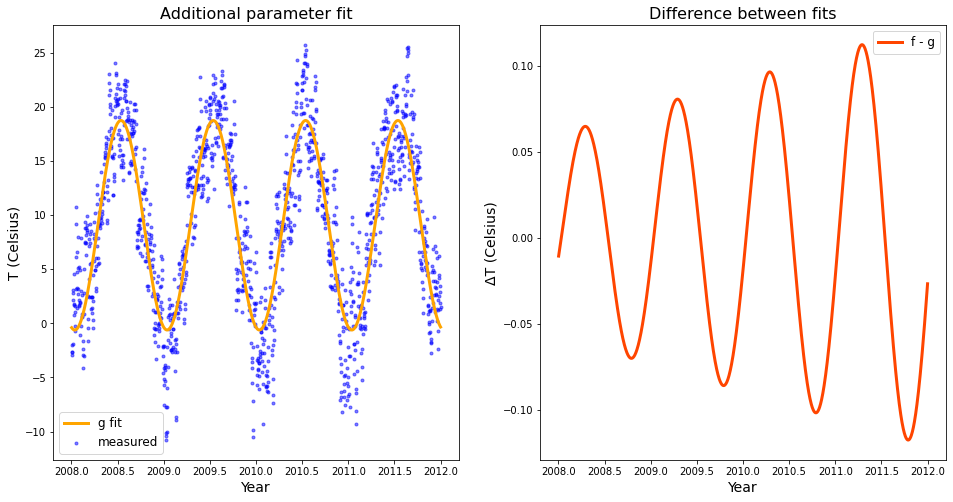

As we can see from the second plot the fitted functions are not exactly the same (though they seem like it at first glance.)


In [9]:
#Now fit the data with the function g(x), which has 1 more parameter than f(x).
def g(t,a,b,c,d):
    return a*np.cos((2*np.pi*b*t) + c) + d

parameters_g, parameter_g_cov = optimize.curve_fit(g, munich_temp_df[0], munich_temp_df[1])

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121)
ax1.set_title('Additional parameter fit', fontsize = 16)
ax1.set_xlabel('Year', size = 14)
ax1.set_ylabel('T (Celsius)',size = 14)
ax1.scatter(df_2008_2012_noout[0], df_2008_2012_noout[1], label = 'measured', color = 'blue', marker = '.', alpha = 0.5)
ax1.plot(df_2008_2012_noout[0], g(df_2008_2012_noout[0], *parameters_g), c = 'orange',label = 'g fit', linewidth = 3)
ax1.legend(loc = 'best', fontsize = 12)


ax2 = fig.add_subplot(122)
ax2.set_title('Difference between fits', fontsize = 16)
ax2.set_xlabel('Year', size = 14)
ax2.set_ylabel('ΔT (Celsius)',size = 14)
ax2.plot(df_2008_2012_noout[0], f(df_2008_2012_noout[0], *parameters)-g(df_2008_2012_noout[0], *parameters_g), c = 'orangered',label = 'f - g', linewidth = 3)
ax2.legend(loc = 'best', fontsize = 12)
plt.show()
print('As we can see from the second plot the fitted functions are not exactly the same (though they seem like it at first glance.)')

In [10]:
#What are the RSS for f(x) and g(x)? Use the Fisher F-test to determine whether the additional parameter is necessary.
     #To do this i clean the original dataset (not only from 2008 to 2012) to remove the outliars.

from scipy import stats
    
munich_temp_df_noout = munich_temp_df.drop(munich_temp_df[abs(munich_temp_df[1]) > 80].index)

def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

g_pred = g(munich_temp_df[0], *parameters_g)
ssr_g = np.sum((g_pred-munich_temp_df_noout[1])**2)
tss = np.sum((np.mean(munich_temp_df_noout[1]) - munich_temp_df_noout[1])**2)
n_dof_g = 3
f_pred = f(munich_temp_df[0], *parameters)
ssr_f = np.sum((f_pred-munich_temp_df_noout[1])**2)
n_dof_f = 2

RSQ_g = 1 - (ssr_g/tss)
RSQ_f = 1 - (ssr_f/tss)
print("R2 of f is  =", RSQ_f)
print("R2 of g is  =", RSQ_g)


print("Fisher Test f vs g:")
cl_f_vs_g = Ftest(ssr_f, ssr_g, n_dof_f, n_dof_g,len(munich_temp_df_noout[0]) , verbose=True)


R2 of f is  = 0.7741513252129325
R2 of g is  = 0.7741973589936557
Fisher Test f vs g:
CL: 0.246 , additional parameter necessary: NO
